In [10]:
import datetime
import numpy as np
import pandas as pd
import gensim
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, TfidfModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import LdaMulticore
import spacy
from nltk.corpus import PlaintextCorpusReader
import os, bz2, time
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# def lemmatize_stemming(stemmer, text):
#     '''lemmatize and stem the text to get key tokens'''
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# # Tokenize and lemmatize
# def preprocess(text, names):
#     '''preprocess the quotation list and extract tokens to dictionary'''
#     result=[]
#     for token in gensim.utils.simple_preprocess(text):
#         if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in names:
#             result.append(lemmatize_stemming(SnowballStemmer("english"), token))
#     return result



# Data preprocessing

In [12]:
# import all quotations data of US
USA_DATA = '../data/quotes_mentions_USA_compact.json.bz2'
df = pd.read_json(USA_DATA, lines=True, compression='bz2' )

In [13]:
df = df.sort_values(by='date', ascending=True)
df

,quoteID,quotation,speaker,qids,date,numOccurrences,phase,mentions,mentions_qids,urls
30190,2015-01-01-004934,David Vitter pursues similar line of attack to...,Chuck Kleckley,Q5115563,2015-01-01 00:16:22,1,E,"[David Vitter, Chuck Kleckley]","[Q519780, Q5115563]",[bayoubuzz.com]
27435,2015-01-01-004937,David Vitter pursues similar line of attack to...,Chuck Kleckley,Q5115563,2015-01-01 00:46:28,1,E,"[David Vitter, Steve Scalise]","[Q519780, Q1857141]",[bayoubuzz.com]
32557,2015-01-01-020316,I've joked around a little bit with Rahm Emanu...,Kirk Caldwell,Q6415403,2015-01-01 01:00:02,8,E,[Rahm Emanuel],[Q298443],"[gantdaily.com, cnn.com, kwch.com, wsbt.com, n..."
41217,2015-01-01-037000,We have expressed our disagreement with the fe...,George W. Bush,Q207,2015-01-01 01:00:02,5,E,[Bill Clinton],[Q1124],"[www.wimsradio.com, 6abc.com, abc7.com, abc7ch..."
43062,2015-01-01-027335,Thank you for your support. Jeb Bush,George W. Bush,Q207,2015-01-01 01:00:02,5,E,[George W. Bush],[Q207],"[www.wimsradio.com, 6abc.com, abc7.com, abc7ch..."
...,...,...,...,...,...,...,...,...,...,...
436341,2020-04-16-008907,"Crazy `Nancy Pelosi, you are a weak person. Yo...",President Trump,Q22686,2020-04-16 20:36:52,1,E,[Nancy Pelosi],[Q170581],[www.sfchronicle.com]
431915,2020-04-16-038512,President Trump has directed our team to devel...,Mike Pence,Q24313,2020-04-16 20:47:30,1,E,[Donald Trump],[Q22686],[www.wtkr.com]
433067,2020-04-16-017107,I don't have the Jared Kushners to call and sa...,Joe Manchin,Q538868,2020-04-16 21:05:00,4,E,[Jared Kushner],[Q13628723],[khn.org]
425295,2020-04-16-012002,"focused on Sleepy Joe Biden,",Linda McMahon,Q233905,2020-04-16 21:05:39,1,E,[Joe Biden],[Q6279],[www.vice.com]


In [4]:
# convert quotations to corpus by year
corpus_root = "./"
for year in range(2015, 2021):
    file_path = '../data/quotations_{:d}.txt'.format(year)
    df_year = df[(df["date"] >= pd.Timestamp(year,1,1)) & (df["date"] < pd.Timestamp(year+1, 1, 1))]
    quotations = "\n".join(df_year["quotation"].to_list())
    print('number of chars {} for year {}'.format(len(quotations), year))

    with open(file_path, 'w') as f:
        f.write(quotations)

number of chars 10079439 for year 2015
number of chars 13294813 for year 2016
number of chars 21151589 for year 2017
number of chars 20394421 for year 2018
number of chars 17056268 for year 2019
number of chars 5227609 for year 2020


In [14]:
# import politician properties and get their names
POLITICIAN = "../data/filtered_politician_labeled_v3.json.bz2"
pol_df = pd.read_json(POLITICIAN, lines=True, compression='bz2')

# extend names with aliases
pol_df['aliases_all'] = [a+[b] for a,b in zip(pol_df['aliases'],pol_df['name'])]
pol_name_global = pol_df["aliases_all"].tolist()
pol_name_global = frozenset([n for names in pol_name_global for n in names])
print("number of total names including aliases of world politicianlen: {}".format(len(pol_name_global)))

number of total names including aliases of world politicianlen: 340939


In [118]:

# US
# pol_name_us = pol_df[pol_df["nationality"] == "Q30"]["aliases_all"].tolist()
# pol_name_us = frozenset([n for names in pol_name_us for n in names])
# pol_name_us

In [119]:
# # import politician properties and get their names
# POLITICIAN = "../data/filtered_politician_labeled_v3.json.bz2"
# pol_df = pd.read_json(POLITICIAN, lines=True, compression='bz2')

# # global
# process_names = [gensim.utils.simple_preprocess(name) for name in pol_df["name"].tolist()]
# global_pol_list = [n for names in process_names for n in names]
# global_pol_names = frozenset(global_pol_list)

# # US
# us_pol_df = pol_df[pol_df["nationality"] == "Q30"]
# process_names = [gensim.utils.simple_preprocess(name) for name in us_pol_df["name"].tolist()]
# # flatten list
# us_pol_list = [n for names in process_names for n in names]
# us_pol_names = frozenset(us_pol_list)

# len(us_pol_names), len(global_pol_names)

In [120]:
# # speed test 
# %timeit "zxczxc" in pol_name_us
# %timeit "zxczxc" in pol_name_global

In [8]:


# initialize NLP pipeline
nlp = spacy.load('en_core_web_sm')
# customize pipeline
nlp.remove_pipe('lemmatizer') # reduce words to basic form, eg. talking -> talk, president -> presid
nlp.remove_pipe('tagger') # tag the part of speech for the token i.e. noun, verb, etc
# nlp.remove_pipe('parser') # dependency parser, maybe removed if adding in bigram 

('tagger', <spacy.pipeline.tagger.Tagger at 0x7fd1b71a3640>)

In [9]:
from nltk.corpus import PlaintextCorpusReader

def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


# read quotations as corpus
corpus_root = "../data"
quotations_corpus = PlaintextCorpusReader(corpus_root, "quotations.*.txt")
quotations_corpus.fileids()

['quotations_2015.txt',
 'quotations_2016.txt',
 'quotations_2017.txt',
 'quotations_2018.txt',
 'quotations_2019.txt',
 'quotations_2020.txt']

In [10]:
# Get the chunks, otherwise too large to handle
corpus_id = {f:n for n,f in enumerate(quotations_corpus.fileids())} # dictionary of books
chunks = list()
chunk_class = list() # this list contains the original book of the chunk, for evaluation

limit = 60 # how many chunks total for one corpus
size = 100 # how many sentences per chunk/page

for f in quotations_corpus.fileids():
    sentences = quotations_corpus.sents(f)
    print(f)
    print('Number of sentences:',len(sentences))

    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()

    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:",len(chs),'\n')

    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([corpus_id[f] for _ in range(len(chs[:limit]))])

quotations_2015.txt
Number of sentences: 74375
Number of chunks: 744 

quotations_2016.txt
Number of sentences: 99133
Number of chunks: 992 

quotations_2017.txt
Number of sentences: 146013
Number of chunks: 1461 

quotations_2018.txt
Number of sentences: 143777
Number of chunks: 1438 

quotations_2019.txt
Number of sentences: 119860
Number of chunks: 1199 

quotations_2020.txt
Number of sentences: 37167
Number of chunks: 372 



In [94]:
# STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

# # get processed corpus by nlp pipeline without removing names
# processed_docs = []
# for doc in nlp.pipe(chunks, n_process=5, batch_size=10):
#      # Process document using Spacy NLP pipeline.
#     ents = doc.ents  # Named entities

#     # Keep only words (no numbers, no punctuation).
#     # Lemmatize tokens, remove punctuation and remove stopwords.
#     # doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
#     # if remove lemmentizer in nlp pipe, what happens here

#     # convert token to string while remove punctuation and stopwords
#     doc = [token.text for token in doc if token.is_alpha and not token.is_stop]

#     # Remove common words from a stopword list and keep only words of length 3 or more.
#     doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

#     # Add named entities, but only if they are a compound of more than word.
#     doc.extend([str(entity) for entity in ents if len(entity) > 1])

#     processed_docs.append(doc)

# docs = processed_docs
# del processed_docs


In [11]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

# get processed corpus by nlp pipeline while removing names

processed_docs = []
for doc in nlp.pipe(chunks, n_process=5, batch_size=10):
     # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # if remove lemmentizer in nlp pipe, what happens here?
    # convert token to string while remove punctuation and stopwords
    doc = [token.text for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    # remove names, have to put after adding entities
    doc = [token for token in doc if token not in pol_name_global and len(token) > 2]

    processed_docs.append(doc)
noname_docs = processed_docs
del processed_docs

In [12]:
# # check if politician names are properly excluded
# for chk in noname_docs:
#     # print('John Bolton' in noname_docs)
#     if 'Donald Trump' in chk:
#     # if 'David' in chk:
#         print('found')
#         break

In [14]:
# "Bernie" in pol_name_global

In [99]:
# # Create a dictionary representation of the documents, and filter out frequent and rare words.
# from gensim.corpora import Dictionary
# dictionary = Dictionary(docs)

# # Remove rare and common tokens.
# # Filter out words that occur too frequently or too rarely.
# max_freq = 0.5
# min_wordcount = 5
# dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# # Bag-of-words representation of the documents.
# corpus = [dictionary.doc2bow(doc) for doc in docs]
# #MmCorpus.serialize("models/corpus.mm", corpus)

# print('Number of unique tokens: %d' % len(dictionary))
# print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 6528
Number of chunks: 500


In [15]:
dictionary = Dictionary(noname_docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.4
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
noname_corpus = [dictionary.doc2bow(doc) for doc in noname_docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(noname_corpus))

Number of unique tokens: 8033
Number of chunks: 360


# Train and Save model

In [100]:
# from gensim.models import LdaMulticore

# seed = 1
# # random.seed(seed)
# np.random.seed(seed)

# params = {'passes': 10, 'random_state': seed}
# base_models = dict()
# model_2020 = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
#                 passes=params['passes'], random_state=params['random_state'])
# model_2020.show_topics(num_topics=5)

[(0,
  '0.003*"office" + 0.002*"Mitch" + 0.002*"party" + 0.002*"witnesses" + 0.002*"economy" + 0.002*"Mitch McConnell" + 0.002*"forward" + 0.002*"military" + 0.002*"continue" + 0.002*"let"'),
 (1,
  '0.002*"won" + 0.002*"coronavirus" + 0.002*"Hunter" + 0.002*"Ukraine" + 0.002*"able" + 0.002*"long" + 0.002*"continue" + 0.002*"Hunter Biden" + 0.002*"important" + 0.002*"sure"'),
 (2,
  '0.002*"coronavirus" + 0.002*"world" + 0.002*"voters" + 0.002*"care" + 0.002*"Ukraine" + 0.002*"let" + 0.002*"job" + 0.002*"day" + 0.002*"didn" + 0.002*"office"'),
 (3,
  '0.002*"year" + 0.002*"Vice" + 0.002*"day" + 0.002*"percent" + 0.002*"didn" + 0.002*"China" + 0.002*"voters" + 0.002*"won" + 0.002*"Ukraine" + 0.002*"sure"')]

In [16]:

seed = 1
# random.seed(seed)
np.random.seed(seed)

params = {'passes': 10, 'random_state': seed}
base_models = dict()
model_LDA_noname = LdaMulticore(corpus=noname_corpus, num_topics=10, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

model_path = "../model/lda_bow"
model_LDA_noname.save(model_path)

model_LDA_noname.show_topics(num_topics=10)

[(0,
  '0.012*"Rubio" + 0.010*"Marco" + 0.008*"Bernie" + 0.008*"Cruz" + 0.007*"Court" + 0.007*"Supreme" + 0.006*"Jeb" + 0.005*"Ted" + 0.005*"South" + 0.004*"Carson"'),
 (1,
  '0.004*"Attorney" + 0.004*"Court" + 0.004*"Gorsuch" + 0.004*"Steve" + 0.004*"marijuana" + 0.004*"Supreme" + 0.003*"Jeff" + 0.003*"Judge" + 0.003*"countries" + 0.003*"nomination"'),
 (2,
  '0.003*"India" + 0.002*"Romney" + 0.002*"class" + 0.002*"financial" + 0.002*"education" + 0.002*"Paul" + 0.002*"ran" + 0.002*"Reagan" + 0.002*"California" + 0.002*"Street"'),
 (3,
  '0.004*"racist" + 0.003*"Jeff" + 0.003*"London" + 0.003*"comments" + 0.003*"Puerto" + 0.002*"Oklahoma" + 0.002*"marijuana" + 0.002*"billion" + 0.002*"sold" + 0.002*"program"'),
 (4,
  '0.005*"class" + 0.004*"middle" + 0.004*"budget" + 0.003*"taxes" + 0.003*"Romney" + 0.003*"Henry" + 0.002*"Mitt" + 0.002*"Jeb" + 0.002*"Keystone" + 0.002*"tonight"'),
 (5,
  '0.005*"Hatch" + 0.005*"Romney" + 0.004*"Orrin" + 0.004*"Utah" + 0.003*"probably" + 0.003*"goes" 

# load model and predict


In [19]:
model_path = '../model/lda_bow'

dictionary = Dictionary.load(model_path+'.id2word')
lda_model = LdaModel.load(model_path)

lda_model.show_topic(0)

[('Rubio', 0.011631411),
 ('Marco', 0.009772583),
 ('Bernie', 0.007733384),
 ('Cruz', 0.007706679),
 ('Court', 0.0073306244),
 ('Supreme', 0.0068143285),
 ('Jeb', 0.0057848063),
 ('Ted', 0.0052659577),
 ('South', 0.0045927837),
 ('Carson', 0.004200234)]

In [20]:
# convert text to bow

# demo with Trump
df_Trump = df[df['qids'] == 'Q22686']
df_Trump_before_election = df_Trump[df_Trump['date'] < pd.Timestamp(2017,1,20)]
df_Trump_early = df_Trump[(df_Trump['date'] > pd.Timestamp(2017,1,20)) & (df_Trump['date'] < pd.Timestamp(2019,1,20))]
df_Trump_late = df_Trump[(df_Trump['date'] > pd.Timestamp(2019,1,20)) & (df_Trump['date'] < pd.Timestamp(2021,1,20))]

In [27]:
nlp = spacy.load('en_core_web_sm')
# customize pipeline
nlp.remove_pipe('lemmatizer') # reduce words to basic form, eg. talking -> talk, president -> presid
nlp.remove_pipe('tagger') # tag the part of speech for the token i.e. noun, verb, etc
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

def preprocess_nlp(docs, nlp, n_process=5, batch_size=10):
    """ get processed corpus by nlp pipeline while removing names """

    processed_docs = []
    for doc in nlp.pipe(docs, n_process=n_process, batch_size=batch_size):
        # Process document using Spacy NLP pipeline.
        ents = doc.ents  # Named entities

        # Keep only words (no numbers, no punctuation).
        # if remove lemmentizer in nlp pipe, what happens here?
        # convert token to string while remove punctuation and stopwords
        doc = [token.text for token in doc if token.is_alpha and not token.is_stop]
        # print(doc)
        # Remove common words from a stopword list and keep only words of length 3 or more.
        doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])

        # remove names, have to put after adding entities
        doc = [token for token in doc if token not in pol_name_global and len(token) > 2]

        processed_docs.append(doc)
    return processed_docs

def domiant_topic(processed_docs, lda_model, dictionary):
    bow_vectors = [dictionary.doc2bow(text) for text in processed_docs]
    
    topic_idx = []
    topic_score = []
    for row in lda_model[bow_vectors]:
        row = sorted(row, key=lambda x: x[1], reverse=True)
        topic_idx.append(row[0][0])
        topic_score.append(row[0][1])
    return topic_idx, topic_score

In [22]:
print(len(df_Trump_before_election))

docs = df_Trump_before_election["quotation"].to_list()
# print('example: ', docs)

processed_docs = preprocess_nlp(docs)
# print('after processing: ', processed_docs)

topic_index, topic_scores = domiant_topic(processed_docs, lda_model, dictionary)

df_Trump_before_election['topic_index'] = topic_index
df_Trump_before_election['topic_scores'] = topic_scores
df_Trump_before_election.head()


# corpus = [id2word.doc2bow(text) for text in data_ready]
# processed_docs
# topic_distribution(processed_docs, lda_model, dictionary)
# processed_docs[0]



18287


/tmp/ipykernel_537/2552915443.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Trump_before_election['topic_index'] = topic_index
/tmp/ipykernel_537/2552915443.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Trump_before_election['topic_scores'] = topic_scores


,quoteID,quotation,speaker,qids,date,numOccurrences,phase,mentions,mentions_qids,urls,topic_index,topic_scores
42679,2015-01-01-016679,Is Trump Going to Run?,Donald Trump,Q22686,2015-01-01 13:24:58,1,E,[Donald Trump],[Q22686],[salon.com],9,0.366753
45567,2015-01-06-072399,Trump was quoted in a Vanity Fair article abou...,Donald Trump,Q22686,2015-01-06 01:13:40,7,E,[Donald Trump],[Q22686],"[watoday.com.au, brisbanetimes.com.au, news.sm...",8,0.617459
22916,2015-01-06-061130,The message pads confiscated from Epstein's ho...,Donald Trump,Q22686,2015-01-06 01:13:40,8,E,[Donald Trump],[Q22686],"[watoday.com.au, brisbanetimes.com.au, news.sm...",8,0.702378
19399,2015-01-06-072400,Trump was quoted in a Vanity Fair article abou...,Donald Trump,Q22686,2015-01-06 23:19:21,1,E,[Donald Trump],[Q22686],[www.brisbanetimes.com.au],8,0.617741
30140,2015-01-12-085262,Whether [ Obama ] is there or Biden is there o...,Donald Trump,Q22686,2015-01-12 14:15:59,1,E,"[Barack Obama, Joe Biden, John Kerry]","[Q76, Q6279, Q22316]",[insider.foxnews.com],0,0.549919


<AxesSubplot:xlabel='topic_index', ylabel='Count'>

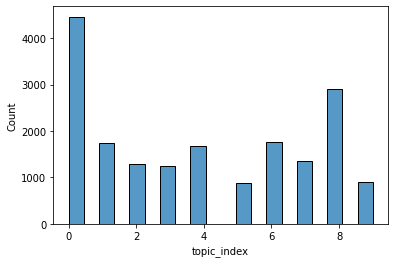

In [23]:
import seaborn  as sns
sns.histplot(df_Trump_before_election['topic_index'])

# Sentiment analysis

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#  for now analyzer is using built-in general purpose lexicon
# can be trained on our own data
sentences = df['quotation'].iloc[:3]
sid = SentimentIntensityAnalyzer()
for s in sentences:
    print(s)
    print(sid.polarity_scores(s)['compound'])


David Vitter pursues similar line of attack to Bobby Jindal on Common Core Chuck Kleckley is considering a run for Louisiana State Treasurer
-0.3818
David Vitter pursues similar line of attack to Bobby Jindal on Common Core Steve Scalise should use House whip position as `bully pulpit' to address racism, Jewish anti-hate group says
-0.802
I've joked around a little bit with Rahm Emanuel, and there's a chance we share parts of it,
0.6705


In [7]:
import os, bz2, time

In [28]:
SAVE_FILE = '../data/quotes_mentions_USA_ML.json.bz2'
READ_FILE = '../data/quotes_mentions_USA_compact.json.bz2'

CHUNKSIZE=5000

try:
    os.remove(SAVE_FILE)
except:
    pass

total_time,total_mentions,chunk_number,nb_quote=0,0,0,0
mentions=[]
sid = SentimentIntensityAnalyzer()

with bz2.open(SAVE_FILE, 'wb') as bz_writer:
    with pd.read_json(READ_FILE, lines=True, chunksize=CHUNKSIZE, compression='bz2' ) as df_reader:
        for chunk in df_reader:
            t1=time.time()

            # LDA topic
            docs = chunk["quotation"].to_list()
            processed_docs = preprocess_nlp(docs, nlp)
            topic_index, topic_scores = domiant_topic(processed_docs, lda_model, dictionary)
            chunk['topic_index'] = topic_index
            chunk['topic_scores'] = topic_scores

            # sentiment analysis
            sentiment_score = [sid.polarity_scores(s)['compound'] for s in docs]
            chunk['sentiment'] = sentiment_score

            chunk.to_json(path_or_buf=bz_writer,orient='records',lines=True)
            mentions = len(chunk)
            total_mentions += mentions
            t2=time.time()
            dt=t2-t1
            total_time+=dt
            chunk_number += 1
            print("Dumped {} quotations out of {} quotations [quotations/s: {:.2f}]".format(mentions, CHUNKSIZE, CHUNKSIZE / dt))

Dumped 5000 quotations out of 5000 quotations [quotations/s: 525.40]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 544.16]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 320.02]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 520.70]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 541.09]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 528.17]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 534.60]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 553.37]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 491.75]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 514.69]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 564.19]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 581.06]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 553.18]
Dumped 5000 quotations out of 5000 quotations [quotations/s: 587.39]
Dumped 5000 quotations out of 5000

In [29]:
SAVE_FILE = '../data/quotes_mentions_USA_ML.json.bz2'
df = pd.read_json(SAVE_FILE, lines=True, compression='bz2' )
df.head(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,phase,mentions,mentions_qids,urls,topic_index,topic_scores,sentiment
0,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,Q359442,2015-10-25 14:12:35,1,E,[Bill Clinton],[Q1124],[examiner.com],8,0.818588,-0.4822
1,2015-08-07-005048,All we ╒ re asking for here is a discussion an...,John Boehner,Q11702,2015-08-07 12:52:52,1,E,[Barack Obama],[Q76],[liveblog.irishtimes.com],8,0.774811,0.0000
2,2015-10-01-005722,An email included in the latest tranche of Cli...,Hillary Clinton,Q6294,2015-10-01 14:56:48,2,E,[Bill Clinton],[Q1124],"[feeds.foxnews.com, www.foxnews.com]",4,0.368826,-0.2732
3,2015-11-17-006368,"and in fact, Secretary of State Kerry was earl...",Phil Bryant,Q887898,2015-11-17 20:03:05,1,E,[John Kerry],[Q22316],[hottytoddy.com],1,0.774721,0.0258
4,2015-02-14-014011,I have fought Obamacare from Day One and will ...,John Cornyn,Q719568,2015-02-14 21:01:51,2,E,[Barack Obama],[Q76],"[www.politico.com, politico.com]",2,0.389230,-0.1280


In [21]:
# tfidf = TfidfModel(corpus=noname_docs, id2word=dictionary)
# tfidf_corpus = tfidf[noname_docs] 

# params = {'passes': 10, 'random_state': seed}
# base_models = dict()
# model_2020_noname_tfidf = LdaMulticore(corpus=tfidf_corpus, num_topics=4, id2word=dictionary, workers=6,
#                 passes=params['passes'], random_state=params['random_state'])
# model_2020_noname_tfidf.show_topics(num_topics=5)

In [22]:
# # pass in name list to remove politician names
# sample_quote = df_2020['quotation'].iloc[0]
# print("Sample quotation: ", sample_quote)
# preprocess(sample_quote, us_pol_names)

In [23]:
# # process 2020 data
# processed_docs = []
# for quotation in df_2020['quotation'].tolist():
#     processed_docs.append(preprocess(quotation, pol_name_us))
# #words into corpus
# dictionary = gensim.corpora.Dictionary(processed_docs)
# #convert to bag of words corpus
# bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [63]:
# tfidf = TfidfModel(bow_corpus, id2word=dictionary)
# tfidf_corpus = tfidf[bow_corpus] 

In [78]:
# # train LDA model with bow corpus
# num_topics = 5
# lda_2020_bow =  gensim.models.LdaMulticore(bow_corpus, 
#                                    num_topics = num_topics, 
#                                    id2word = dictionary,                                    
#                                    passes = 10)
# MODEL_PATH = "./lda_bow_2020"
# lda_2020_bow.save(MODEL_PATH)

In [24]:
# # analyze model
# for idx, topic in lda_2020_bow.print_topics(-1):
#     print("Topic: {} \nWords: {}".format(idx, topic))
#     print("\n")

In [25]:
# # train LDA model with tfidf corpus
# num_topics = 5
# lda_2020_tfidf =  gensim.models.LdaMulticore(tfidf_corpus, 
#                                    num_topics = num_topics, 
#                                    id2word = dictionary,                                    
#                                    passes = 10)
# MODEL_PATH = "./lda_tfidf_2020"
# lda_2020_tfidf.save(MODEL_PATH)

In [26]:
# # analyze model
# for idx, topic in lda_2020_tfidf.print_topics(-1):
#     print("Topic: {} \nWords: {}".format(idx, topic))
#     print("\n")

In [27]:
# # use the model to predict
# test_document = df_2020['quotation'].iloc[0]
# test_processed = preprocess(test_document, us_pol_names)
# bow_vector = dictionary.doc2bow(test_processed)

# # bow model
# print('original quotation: "{}"'.format(test_document))
# print('processed input: "{}"'.format(test_processed))
# for index, score in sorted(lda_2020_bow[bow_vector], key=lambda tup: -1*tup[1]):
#     print("Score: {}\t Topic: {}".format(score, lda_2020_bow.print_topic(index, 5)))

In [28]:
# # tfidf model 
# print('original quotation: "{}"'.format(test_document))
# print('processed input: "{}"'.format(test_processed))
# for index, score in sorted(lda_2020_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
#     print("Score: {}\t Topic: {}".format(score, lda_2020_tfidf.print_topic(index, 5)))